# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import os 
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.misc import imsave
from scipy.misc import imresize
import numpy as np
from numpy import genfromtxt
import tensorflow as tf
from PIL import Image
import pickle
# from tensorflow_vgg import vgg16|
import collections
import time
import math

# Import GEI dataset 

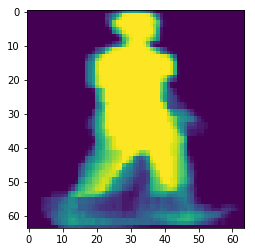

In [34]:
img = imread('{}'.format(os.path.join('OULP-C1V2_Pack/GEI/OULP-GEI-(224x224)-15f/Seq00/0000024', '0000024_55_GEI_15f.png')))
img = imresize(img, [64, 64], interp='nearest')
plt.imshow(img)
plt.show()

In [45]:
# Create Training Data
path = 'OULP-C1V2_Pack/GEI/OULP-GEI-(224x224)/Seq01'
Seq_15f_list = os.listdir(path)
Seq_15f_list.remove('.DS_Store')

Seq = []
for each_seq in Seq_15f_list:
    seq_path = os.path.join(path, each_seq)
    GEI = []
    for each_GEI in os.listdir(seq_path):
        img = imread('{}'.format(os.path.join(seq_path, each_GEI)))
        img = imresize(img, [64, 64], interp='nearest')
        GEI.append(img)
    Seq.append(np.array(GEI))
Seq = np.array(Seq)

In [46]:
with open('../gait_data/OULP_GEI/codes', 'wb') as f:
    np.save(f, Seq)

# Checkpoint 1

In [2]:
# gallery_15f = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_15f_Seq00', mode='rb'))
# probe_15f = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_15f_Seq01', mode='rb'))
gallery_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_full_Seq00', mode='rb'))
probe_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_full_Seq01', mode='rb'))

In [3]:
gallery_full = gallery_full/float(255)
probe_full = probe_full/float(255)

<br><br><br><br><br><br><br><br><br>

# Auto_Encoder 2: 65''-75''
### 先试full-full

In [4]:
# Train X
train_x = np.concatenate([gallery_full[:2800, 1], probe_full[:2800, 1]], axis=0)
train_x = np.reshape(train_x, [train_x.shape[0], train_x.shape[1], train_x.shape[2], 1])
# Train Y
train_y = np.concatenate([gallery_full[:2800, 2], probe_full[:2800, 2]], axis=0)
train_y = np.reshape(train_x, [train_x.shape[0], train_x.shape[1], train_x.shape[2], 1])
print('train_x', train_x.shape, 'train_y', train_y.shape)

# Val X
val_x = gallery_full[2800:, 1]
val_x = np.reshape(val_x, [val_x.shape[0], val_x.shape[1], val_x.shape[2], 1])
# Val Y
val_y = gallery_full[2800:, 2]
val_y = np.reshape(val_y, [val_y.shape[0], val_y.shape[1], val_y.shape[2], 1])
print('val_x', val_x.shape, 'val_y', val_y.shape)

# Test X
test_x = probe_full[2800:, 1]
test_x = np.reshape(test_x, [test_x.shape[0], test_x.shape[1], test_x.shape[2], 1])
# Test Y
test_y = probe_full[2800:, 2]
test_y = np.reshape(test_x, [test_x.shape[0], test_x.shape[1], test_x.shape[2], 1])
print('test_x', test_x.shape, 'test_y', test_y.shape)

train_x (5600, 64, 64, 1) train_y (5600, 64, 64, 1)
val_x (346, 64, 64, 1) val_y (346, 64, 64, 1)
test_x (346, 64, 64, 1) test_y (346, 64, 64, 1)


# Create Graph

In [5]:
def build_inputs_outputs():
    inputs_1 = tf.placeholder(tf.float32, (None, 64, 64, 1), name='inputs_1')
    targets_1 = tf.placeholder(tf.float32, (None, 64, 64, 1), name='targets_1')
    
    return inputs_1, targets_1

def conv_layer(inputs_, conv_name, pool_name, bn_name, relu_name, add_bacth_norm=True, is_training=True, out_dim=1, 
               kern_size=(2,2), conv_strides=(1,1), pool_size=(2,2), pool_strides=(2,2), keep_prob=0.5):
    ### Encoder
    # e.g. out_dim: 8; kern_size: (3,3); pool_size: (2,2); strides: (2,2);
    conv = tf.layers.conv2d(inputs_, out_dim, kern_size, strides=conv_strides, padding='same', activation=None,
                            name=conv_name)
    # Now 28x28x
    if add_bacth_norm:
        conv = tf.layers.batch_normalization(conv, training=is_training, name=bn_name)
        
    conv = tf.nn.relu(conv, name=relu_name)
        
    maxpool = tf.layers.max_pooling2d(conv, pool_size, pool_strides, padding='same', name=pool_name)
    
    maxpool = tf.layers.dropout(maxpool, rate=keep_prob)

    return maxpool

#     # Now 14x14x16
#     conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 14x14x8
#     maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
#     # Now 7x7x8
#     conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 7x7x8
#     encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
#     # Now 4x4x8
maxpool
def deconv_layer(encoded, up_name, conv_name, bn_name, relu_name, add_batch_norm=True, is_training=True, 
                 up_size=(2,2), out_dim=1, kern_size=(2,2), conv_strides=(1,1), keep_prob=0.5):
    ### Decoder
    upsample = tf.image.resize_nearest_neighbor(encoded, up_size, name=up_name) # up_size: e.g.(7,7)
    # Now 7x7x8 kern_size: (3, 3)
    conv = tf.layers.conv2d(upsample, out_dim, kern_size, strides=conv_strides, padding='same', activation=None, 
                            name=conv_name) 
    
    if add_batch_norm:
        conv = tf.layers.batch_normalization(conv, training=is_training, name=bn_name)
    
    conv = tf.nn.relu(conv, name=relu_name)
    
    conv = tf.layers.dropout(conv, rate=keep_prob)
    
    return conv

#     # Now 7x7x8
#     upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))maxpool
#     # Now 14x14x8
#     conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 14x14x8
#     upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
#     # Now 28x28x8
#     conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 28x28x16

def output_layer(conv, logits_name, bn_name, decoded_name, add_batch_norm=True, is_training=True, 
                 out_dim=1, kern_size=(3,3), conv_strides=(1,1)):
    logits = tf.layers.conv2d(conv, out_dim, kern_size, strides=conv_strides, padding='same', activation=None, 
                              name=logits_name)
    
    if add_batch_norm:
        conv = tf.layers.batch_normalization(conv, training=is_training, name=bn_name)
    #Now 28x28x1
    decoded = tf.nn.sigmoid(logits, name=decoded_name)
    
    return logits, decoded

In [6]:
def build_graph(kern_size, conv_strides, pool_size, pool_strides, de_kern_size, 
                de_conv_strides, out_kern_size, out_strides, up_size=[(16,16), (32,32), (64,64)], is_training=True):
    
    # reset graph
    tf.reset_default_graph()
    
    with tf.name_scope('inputs_targets'):
        inputs_1, targets_1 = build_inputs_outputs()
    
    keep_p = tf.placeholder(tf.float32, name="keep_prob")
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    with tf.name_scope('conv_layers'):
        
        maxpool_1 = conv_layer(inputs_1, 'conv_1', 'pool_1', 'bn_1', 'relu_1', add_bacth_norm=False, 
                               is_training=is_training, out_dim=16, kern_size=kern_size, conv_strides=conv_strides, 
                               pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
        
        maxpool_2 = conv_layer(maxpool_1, 'conv_2', 'pool_2', 'bn_2', 'relu_2', add_bacth_norm=True, 
                               is_training=is_training, out_dim=8, kern_size=kern_size, conv_strides=conv_strides, 
                               pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
        
        maxpool_3 = conv_layer(maxpool_2, 'conv_3', 'pool_3', 'bn_3', 'relu_3', add_bacth_norm=True, 
                               is_training=is_training, out_dim=8, kern_size=kern_size, conv_strides=conv_strides, 
                               pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
        
    with tf.name_scope('deconv_layers'):
        
        deconv_1 = deconv_layer(maxpool_3, 'up_1', 'deconv_1', 'de_bn_1', 'de_relu_1', add_batch_norm=True, 
                              is_training=is_training, up_size=up_size[0], out_dim=8, kern_size=de_kern_size,
                              conv_strides=de_conv_strides, keep_prob=keep_p)
        
        deconv_2 = deconv_layer(deconv_1, 'up_2', 'deconv_2', 'de_bn_2', 'de_relu_2', add_batch_norm=True, 
                              is_training=is_training, up_size=up_size[1], out_dim=8, kern_size=de_kern_size,
                              conv_strides=de_conv_strides, keep_prob=keep_p)
        
        deconv_3 = deconv_layer(deconv_2, 'up_3', 'deconv_3', 'de_bn_3', 'de_relu_3', add_batch_norm=True, 
                              is_training=is_training, up_size=up_size[2], out_dim=16, kern_size=de_kern_size,
                              conv_strides=de_conv_strides, keep_prob=keep_p)
        
    with tf.name_scope('output_layer'):
        
        logits, decoded = output_layer(deconv_3, 'logits', 'bn', 'decoded', add_batch_norm=True, is_training=is_training, 
                                       out_dim=1, kern_size=out_kern_size, conv_strides=out_strides)
        
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_1, logits=logits, name='loss')
    cost = tf.reduce_mean(loss, name='cost')
    opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with tf.name_scope('saver'):
        saver = tf.train.Saver()
        
#     merged = tf.summary.merge_all()
    
    export_nodes = ['inputs_1', 'targets_1', 'maxpool_1', 'maxpool_2', 'maxpool_3', 'deconv_1', 'deconv_2', 
                    'deconv_3', 'logits', 'decoded', 'loss', 'cost', 'opt', 'saver', 'learning_rate', 'keep_p']
    
    Graph = collections.namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

In [7]:
def get_batches(data, target, batch_size):
    n_batches = len(data)//batch_size
    data = data[:batch_size * n_batches]
    target = target[:batch_size * n_batches]
    for ii in range(0, batch_size*n_batches, batch_size):
        data_batch = data[ii:ii + batch_size]
        target_batch = target[ii:ii + batch_size]
        
        yield data_batch, target_batch
        
        
def cal_accuracy(decoded, target):
    error = abs(decoded - target)
    Acc = (np.sum(error <= 0.1)/(decoded.shape[0]*decoded.shape[1]*decoded.shape[2]*decoded.shape[3]))*100
    
    return Acc

In [8]:
error = np.random.rand(10,5,5,1)
np.sum(error >= 0.9)/100

0.14999999999999999

In [9]:
def train(model, epochs, save_string):

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())
        
        iteration = 1
        mean_val_loss = 0
        mean_val_acc = 0
        count_loss_not_decrease_epochs = 0
        count_acc_not_decrease_epochs = 0
        Last_val_loss = 0
        Last_val_acc = 0
        
        
        for e in range(epochs):
            for train_batch, target_batch in get_batches(train_x, train_y, batch_size):
                    
                start = time.time()
                
                feed_1 = {
                        model.inputs_1: train_batch, 
                        model.targets_1: target_batch,
                        model.keep_p: 0.6,
                        model.learning_rate: lr
                        }

                train_loss, _, decoded_img = sess.run([model.cost, model.opt, model.decoded], feed_dict=feed_1)
                
                train_acc = cal_accuracy(decoded_img, target_batch)
                
                if iteration%25==0:
                    end = time.time()
#                     acc = calculate_accuracy(sess, pred, target_batch, sq_length)
                    print("Epoch: {}/{},".format(e+1, epochs),' '
                          "Iteration: {},".format(iteration),' '
                          "Train loss: {:.3f},".format(train_loss),'      '
                          "{:.1f}s /batch.".format((end-start)/5),' '
                          "Train Accuracy: %{:.3f}".format(train_acc))

                ##############################################################
                ######################## VALIDATION ##########################
                ##############################################################
                
                if iteration%75==0:
#                     training = True
                    validation_loss = []
                    validation_acc = []
                    
                    if batch_size >= len(val_x):
                        val_batch_size = len(val_x)
                    else: 
                        val_batch_size = batch_size
                        

                    for ii, (val_batch, val_target_batch) in enumerate(get_batches(val_x, val_y, val_batch_size)):
#                         print(ii, len(val_x)//val_batch_size)
                        feed_2 = {
                                model.inputs_1: val_batch,
                                model.targets_1: val_target_batch,
                                model.keep_p: 1
                                }
                        
                        val_loss, val_decoded_img, max_pool_3 = sess.run([model.cost, model.decoded, model.maxpool_3], 
                                                                          feed_dict=feed_2)

                        val_acc = cal_accuracy(val_decoded_img, val_target_batch)
                        
                        validation_loss.append(val_loss)
                        validation_acc.append(val_acc)
                    
                    Last_val_loss = mean_val_loss
                    Last_val_acc = mean_val_acc
                    mean_val_loss = np.mean(np.array(validation_loss))
                    mean_val_acc = np.mean(np.array(validation_acc))
                    
                    print()
                    print("Validation loss: {:.3f},".format(mean_val_loss),' '
                          "Validation accuracy: {:.3f},".format(mean_val_acc),' '
                          "maxpool_3.shape: {}.".format(max_pool_3[0].shape))
                    print()
                        
                ####### plot #######
                if iteration%500==0:
                    
                    feed_3 = {
                            model.inputs_1: val_x[:10],
                            model.keep_p: 1
                            }
                    
                    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
                    in_imgs = val_y[:10]
                    reconstructed = sess.run(model.decoded, feed_dict=feed_3)

                    # plot out
                    for images, row in zip([in_imgs, reconstructed], axes):
                        for img, ax in zip(images, row):
                            ax.imshow(img.reshape((64, 64)), cmap='Greys_r')
                            ax.get_xaxis().set_visible(False)
                            ax.get_yaxis().set_visible(False)


                    fig.tight_layout(pad=0.1)
                            
                    
                    
                    
                    
                iteration += 1
                
#             # Early stopping  
#             if mean_val_Acc - Last_val_Acc <= -0.3:
#                 count_Acc_not_increase_epochs += 1
#             if Last_val_loss - mean_val_loss <= -0.01:
#                 count_loss_not_decrease_epochs += 1
                
#             if mean_val_Acc - Last_val_Acc <= -2:
#                 break
#             if count_Acc_not_increase_epochs >= 10:
#                 break
#             if count_loss_not_decrease_epochs >= 10:
#                 break
                
        model.saver.save(sess, r"{}".format(save_string))

In [ ]:
!mkdir checkpoints_view_invariant

Au = 2
training = True
num_layers = 3
epochs = 1700
batch_size = 80
conv_kern_size = (3,3)
conv_strides = (1,1)
pool_size = (2,2)
pool_strides = (2,2)
up_size = [(16,16), (32,32), (64,64)]
de_kern_size = (3,3)
de_conv_strides = (1,1)
out_kern_size = (3,3)
out_strides = (1,1)

for lr in [0.001]:
#                 log_string = 'logs/4/lr={},nl={},ls={},bs={}'.format(lr, num_layers, lstm_size, batch_size)
    save_string = './checkpoints_view_invariant/Au={}_lr={}_nl={}_bs={}.ckpt'.format(Au, lr, num_layers, batch_size)
                
#             writer = tf.summary.FileWriter(log_string)
                                
    model = build_graph(conv_kern_size, conv_strides, pool_size, pool_strides, de_kern_size, de_conv_strides,
                        out_kern_size, out_strides, up_size=up_size, is_training=training)

    train(model, epochs, save_string)
                
    print(' ')
    print(' ')
    print("leraning_rate={},num_layers={},batch_size={} finished, saved".format(lr, num_layers, batch_size))
    print(' ')
    print(' ')

mkdir: cannot create directory ‘checkpoints_view_invariant’: File exists
Epoch: 1/1700,  Iteration: 25,  Train loss: 0.302,       0.0s /batch.  Train Accuracy: %54.326
Epoch: 1/1700,  Iteration: 50,  Train loss: 0.253,       0.0s /batch.  Train Accuracy: %77.640
Epoch: 2/1700,  Iteration: 75,  Train loss: 0.239,       0.0s /batch.  Train Accuracy: %83.131

Validation loss: 0.231,  Validation accuracy: 80.484,  maxpool_3.shape: (8, 8, 8).

Epoch: 2/1700,  Iteration: 100,  Train loss: 0.225,       0.0s /batch.  Train Accuracy: %85.132
Epoch: 2/1700,  Iteration: 125,  Train loss: 0.221,       0.0s /batch.  Train Accuracy: %86.652
Epoch: 3/1700,  Iteration: 150,  Train loss: 0.222,       0.0s /batch.  Train Accuracy: %89.023

Validation loss: 0.217,  Validation accuracy: 84.539,  maxpool_3.shape: (8, 8, 8).

Epoch: 3/1700,  Iteration: 175,  Train loss: 0.218,       0.0s /batch.  Train Accuracy: %89.339
Epoch: 3/1700,  Iteration: 200,  Train loss: 0.217,       0.0s /batch.  Train Accuracy: 

Epoch: 24/1700,  Iteration: 1675,  Train loss: 0.206,       0.0s /batch.  Train Accuracy: %95.944
Epoch: 25/1700,  Iteration: 1700,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %96.068
Epoch: 25/1700,  Iteration: 1725,  Train loss: 0.212,       0.0s /batch.  Train Accuracy: %96.255

Validation loss: 0.208,  Validation accuracy: 88.898,  maxpool_3.shape: (8, 8, 8).

Epoch: 25/1700,  Iteration: 1750,  Train loss: 0.212,       0.0s /batch.  Train Accuracy: %96.028
Epoch: 26/1700,  Iteration: 1775,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %95.541
Epoch: 26/1700,  Iteration: 1800,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %96.408

Validation loss: 0.209,  Validation accuracy: 88.544,  maxpool_3.shape: (8, 8, 8).

Epoch: 27/1700,  Iteration: 1825,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %96.268
Epoch: 27/1700,  Iteration: 1850,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %96.026
Epoch: 27/1700,  Iteration: 1875,  Train loss:

Epoch: 48/1700,  Iteration: 3325,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %96.880
Epoch: 48/1700,  Iteration: 3350,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %96.666
Epoch: 49/1700,  Iteration: 3375,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %96.982

Validation loss: 0.211,  Validation accuracy: 88.412,  maxpool_3.shape: (8, 8, 8).

Epoch: 49/1700,  Iteration: 3400,  Train loss: 0.212,       0.0s /batch.  Train Accuracy: %96.689
Epoch: 49/1700,  Iteration: 3425,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %97.029
Epoch: 50/1700,  Iteration: 3450,  Train loss: 0.201,       0.0s /batch.  Train Accuracy: %96.901

Validation loss: 0.205,  Validation accuracy: 90.066,  maxpool_3.shape: (8, 8, 8).

Epoch: 50/1700,  Iteration: 3475,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %97.181
Epoch: 50/1700,  Iteration: 3500,  Train loss: 0.211,       0.0s /batch.  Train Accuracy: %96.888
Epoch: 51/1700,  Iteration: 3525,  Train loss:

Epoch: 72/1700,  Iteration: 4975,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %97.398
Epoch: 72/1700,  Iteration: 5000,  Train loss: 0.201,       0.0s /batch.  Train Accuracy: %97.339
Epoch: 72/1700,  Iteration: 5025,  Train loss: 0.200,       0.0s /batch.  Train Accuracy: %97.348

Validation loss: 0.206,  Validation accuracy: 90.065,  maxpool_3.shape: (8, 8, 8).

Epoch: 73/1700,  Iteration: 5050,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %97.573
Epoch: 73/1700,  Iteration: 5075,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %97.251
Epoch: 73/1700,  Iteration: 5100,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %97.139

Validation loss: 0.206,  Validation accuracy: 90.216,  maxpool_3.shape: (8, 8, 8).

Epoch: 74/1700,  Iteration: 5125,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %97.280
Epoch: 74/1700,  Iteration: 5150,  Train loss: 0.211,       0.0s /batch.  Train Accuracy: %97.245
Epoch: 74/1700,  Iteration: 5175,  Train loss:

Epoch: 95/1700,  Iteration: 6625,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %97.786
Epoch: 95/1700,  Iteration: 6650,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %97.536
Epoch: 96/1700,  Iteration: 6675,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %97.242

Validation loss: 0.205,  Validation accuracy: 90.419,  maxpool_3.shape: (8, 8, 8).

Epoch: 96/1700,  Iteration: 6700,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %97.698
Epoch: 97/1700,  Iteration: 6725,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %97.609
Epoch: 97/1700,  Iteration: 6750,  Train loss: 0.200,       0.0s /batch.  Train Accuracy: %97.603

Validation loss: 0.209,  Validation accuracy: 89.419,  maxpool_3.shape: (8, 8, 8).

Epoch: 97/1700,  Iteration: 6775,  Train loss: 0.200,       0.0s /batch.  Train Accuracy: %97.574
Epoch: 98/1700,  Iteration: 6800,  Train loss: 0.206,       0.0s /batch.  Train Accuracy: %97.794
Epoch: 98/1700,  Iteration: 6825,  Train loss:

Epoch: 118/1700,  Iteration: 8250,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %97.623

Validation loss: 0.206,  Validation accuracy: 90.342,  maxpool_3.shape: (8, 8, 8).

Epoch: 119/1700,  Iteration: 8275,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %97.606
Epoch: 119/1700,  Iteration: 8300,  Train loss: 0.211,       0.0s /batch.  Train Accuracy: %97.599
Epoch: 119/1700,  Iteration: 8325,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %97.770

Validation loss: 0.208,  Validation accuracy: 89.767,  maxpool_3.shape: (8, 8, 8).

Epoch: 120/1700,  Iteration: 8350,  Train loss: 0.200,       0.0s /batch.  Train Accuracy: %97.595
Epoch: 120/1700,  Iteration: 8375,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %97.977
Epoch: 120/1700,  Iteration: 8400,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %97.707

Validation loss: 0.206,  Validation accuracy: 90.248,  maxpool_3.shape: (8, 8, 8).

Epoch: 121/1700,  Iteration: 8425,  Train loss: 0.20

Epoch: 141/1700,  Iteration: 9850,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %97.914
Epoch: 142/1700,  Iteration: 9875,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %97.839
Epoch: 142/1700,  Iteration: 9900,  Train loss: 0.200,       0.0s /batch.  Train Accuracy: %97.868

Validation loss: 0.208,  Validation accuracy: 89.507,  maxpool_3.shape: (8, 8, 8).

Epoch: 142/1700,  Iteration: 9925,  Train loss: 0.200,       0.0s /batch.  Train Accuracy: %97.809
Epoch: 143/1700,  Iteration: 9950,  Train loss: 0.206,       0.0s /batch.  Train Accuracy: %98.036
Epoch: 143/1700,  Iteration: 9975,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %97.781

Validation loss: 0.207,  Validation accuracy: 90.311,  maxpool_3.shape: (8, 8, 8).

Epoch: 143/1700,  Iteration: 10000,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %97.715
Epoch: 144/1700,  Iteration: 10025,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %97.776
Epoch: 144/1700,  Iteration: 10050, 

/usr/home/rez/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 151/1700,  Iteration: 10525,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %97.575
Epoch: 151/1700,  Iteration: 10550,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %97.971
Epoch: 152/1700,  Iteration: 10575,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %97.857

Validation loss: 0.204,  Validation accuracy: 90.552,  maxpool_3.shape: (8, 8, 8).

Epoch: 152/1700,  Iteration: 10600,  Train loss: 0.200,       0.0s /batch.  Train Accuracy: %97.928
Epoch: 152/1700,  Iteration: 10625,  Train loss: 0.200,       0.0s /batch.  Train Accuracy: %97.858
Epoch: 153/1700,  Iteration: 10650,  Train loss: 0.206,       0.0s /batch.  Train Accuracy: %98.066

Validation loss: 0.205,  Validation accuracy: 90.348,  maxpool_3.shape: (8, 8, 8).

Epoch: 153/1700,  Iteration: 10675,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %97.824
Epoch: 153/1700,  Iteration: 10700,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %97.748
Epoch: 154/1700,  Iteration: 1

Epoch: 174/1700,  Iteration: 12150,  Train loss: 0.211,       0.0s /batch.  Train Accuracy: %97.742

Validation loss: 0.205,  Validation accuracy: 90.211,  maxpool_3.shape: (8, 8, 8).

Epoch: 174/1700,  Iteration: 12175,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %97.997
Epoch: 175/1700,  Iteration: 12200,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %97.864
Epoch: 175/1700,  Iteration: 12225,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.187

Validation loss: 0.206,  Validation accuracy: 89.953,  maxpool_3.shape: (8, 8, 8).

Epoch: 175/1700,  Iteration: 12250,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %97.999
Epoch: 176/1700,  Iteration: 12275,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %97.679
Epoch: 176/1700,  Iteration: 12300,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.053

Validation loss: 0.210,  Validation accuracy: 89.209,  maxpool_3.shape: (8, 8, 8).

Epoch: 177/1700,  Iteration: 12325,  Train lo

Epoch: 197/1700,  Iteration: 13750,  Train loss: 0.200,       0.0s /batch.  Train Accuracy: %98.072
Epoch: 197/1700,  Iteration: 13775,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.004
Epoch: 198/1700,  Iteration: 13800,  Train loss: 0.206,       0.0s /batch.  Train Accuracy: %98.176

Validation loss: 0.205,  Validation accuracy: 90.428,  maxpool_3.shape: (8, 8, 8).

Epoch: 198/1700,  Iteration: 13825,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %97.960
Epoch: 198/1700,  Iteration: 13850,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %97.894
Epoch: 199/1700,  Iteration: 13875,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %97.994

Validation loss: 0.211,  Validation accuracy: 88.923,  maxpool_3.shape: (8, 8, 8).

Epoch: 199/1700,  Iteration: 13900,  Train loss: 0.211,       0.0s /batch.  Train Accuracy: %97.832
Epoch: 199/1700,  Iteration: 13925,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.075
Epoch: 200/1700,  Iteration: 1

Epoch: 220/1700,  Iteration: 15375,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.288

Validation loss: 0.206,  Validation accuracy: 90.037,  maxpool_3.shape: (8, 8, 8).

Epoch: 220/1700,  Iteration: 15400,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.105
Epoch: 221/1700,  Iteration: 15425,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %97.748
Epoch: 221/1700,  Iteration: 15450,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.086

Validation loss: 0.210,  Validation accuracy: 89.250,  maxpool_3.shape: (8, 8, 8).

Epoch: 222/1700,  Iteration: 15475,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.070
Epoch: 222/1700,  Iteration: 15500,  Train loss: 0.200,       0.0s /batch.  Train Accuracy: %98.136
Epoch: 222/1700,  Iteration: 15525,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.071

Validation loss: 0.206,  Validation accuracy: 90.325,  maxpool_3.shape: (8, 8, 8).

Epoch: 223/1700,  Iteration: 15550,  Train lo

Epoch: 243/1700,  Iteration: 16975,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.069
Epoch: 243/1700,  Iteration: 17000,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %97.994
Epoch: 244/1700,  Iteration: 17025,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.050

Validation loss: 0.211,  Validation accuracy: 88.878,  maxpool_3.shape: (8, 8, 8).

Epoch: 244/1700,  Iteration: 17050,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %97.908
Epoch: 244/1700,  Iteration: 17075,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.196
Epoch: 245/1700,  Iteration: 17100,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.058

Validation loss: 0.206,  Validation accuracy: 90.415,  maxpool_3.shape: (8, 8, 8).

Epoch: 245/1700,  Iteration: 17125,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.371
Epoch: 245/1700,  Iteration: 17150,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.135
Epoch: 246/1700,  Iteration: 1

Epoch: 266/1700,  Iteration: 18600,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.176

Validation loss: 0.210,  Validation accuracy: 89.319,  maxpool_3.shape: (8, 8, 8).

Epoch: 267/1700,  Iteration: 18625,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.183
Epoch: 267/1700,  Iteration: 18650,  Train loss: 0.200,       0.0s /batch.  Train Accuracy: %98.213
Epoch: 267/1700,  Iteration: 18675,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.143

Validation loss: 0.206,  Validation accuracy: 90.410,  maxpool_3.shape: (8, 8, 8).

Epoch: 268/1700,  Iteration: 18700,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.338
Epoch: 268/1700,  Iteration: 18725,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.110
Epoch: 268/1700,  Iteration: 18750,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.015

Validation loss: 0.205,  Validation accuracy: 90.525,  maxpool_3.shape: (8, 8, 8).

Epoch: 269/1700,  Iteration: 18775,  Train lo

Epoch: 289/1700,  Iteration: 20200,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.011
Epoch: 289/1700,  Iteration: 20225,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.279
Epoch: 290/1700,  Iteration: 20250,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.137

Validation loss: 0.206,  Validation accuracy: 90.475,  maxpool_3.shape: (8, 8, 8).

Epoch: 290/1700,  Iteration: 20275,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.449
Epoch: 290/1700,  Iteration: 20300,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.196
Epoch: 291/1700,  Iteration: 20325,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %97.909

Validation loss: 0.206,  Validation accuracy: 90.505,  maxpool_3.shape: (8, 8, 8).

Epoch: 291/1700,  Iteration: 20350,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.209
Epoch: 292/1700,  Iteration: 20375,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.220
Epoch: 292/1700,  Iteration: 2

Epoch: 312/1700,  Iteration: 21825,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.212

Validation loss: 0.206,  Validation accuracy: 90.460,  maxpool_3.shape: (8, 8, 8).

Epoch: 313/1700,  Iteration: 21850,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.401
Epoch: 313/1700,  Iteration: 21875,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.158
Epoch: 313/1700,  Iteration: 21900,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.096

Validation loss: 0.206,  Validation accuracy: 90.545,  maxpool_3.shape: (8, 8, 8).

Epoch: 314/1700,  Iteration: 21925,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.228
Epoch: 314/1700,  Iteration: 21950,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.074
Epoch: 314/1700,  Iteration: 21975,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.319

Validation loss: 0.207,  Validation accuracy: 90.012,  maxpool_3.shape: (8, 8, 8).

Epoch: 315/1700,  Iteration: 22000,  Train lo

Epoch: 335/1700,  Iteration: 23425,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.531
Epoch: 335/1700,  Iteration: 23450,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.225
Epoch: 336/1700,  Iteration: 23475,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %97.975

Validation loss: 0.205,  Validation accuracy: 90.502,  maxpool_3.shape: (8, 8, 8).

Epoch: 336/1700,  Iteration: 23500,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.276
Epoch: 337/1700,  Iteration: 23525,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.299
Epoch: 337/1700,  Iteration: 23550,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.333

Validation loss: 0.207,  Validation accuracy: 89.988,  maxpool_3.shape: (8, 8, 8).

Epoch: 337/1700,  Iteration: 23575,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.310
Epoch: 338/1700,  Iteration: 23600,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.449
Epoch: 338/1700,  Iteration: 2

Epoch: 358/1700,  Iteration: 25050,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.167

Validation loss: 0.205,  Validation accuracy: 90.537,  maxpool_3.shape: (8, 8, 8).

Epoch: 359/1700,  Iteration: 25075,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.308
Epoch: 359/1700,  Iteration: 25100,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.136
Epoch: 359/1700,  Iteration: 25125,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.382

Validation loss: 0.207,  Validation accuracy: 90.095,  maxpool_3.shape: (8, 8, 8).

Epoch: 360/1700,  Iteration: 25150,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.244
Epoch: 360/1700,  Iteration: 25175,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.551
Epoch: 360/1700,  Iteration: 25200,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.247

Validation loss: 0.206,  Validation accuracy: 90.323,  maxpool_3.shape: (8, 8, 8).

Epoch: 361/1700,  Iteration: 25225,  Train lo

Epoch: 381/1700,  Iteration: 26650,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.376
Epoch: 382/1700,  Iteration: 26675,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.361
Epoch: 382/1700,  Iteration: 26700,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.372

Validation loss: 0.207,  Validation accuracy: 89.996,  maxpool_3.shape: (8, 8, 8).

Epoch: 382/1700,  Iteration: 26725,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.322
Epoch: 383/1700,  Iteration: 26750,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.511
Epoch: 383/1700,  Iteration: 26775,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.214

Validation loss: 0.207,  Validation accuracy: 90.457,  maxpool_3.shape: (8, 8, 8).

Epoch: 383/1700,  Iteration: 26800,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.173
Epoch: 384/1700,  Iteration: 26825,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.340
Epoch: 384/1700,  Iteration: 2

Epoch: 404/1700,  Iteration: 28275,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.432

Validation loss: 0.207,  Validation accuracy: 90.132,  maxpool_3.shape: (8, 8, 8).

Epoch: 405/1700,  Iteration: 28300,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.267
Epoch: 405/1700,  Iteration: 28325,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.587
Epoch: 405/1700,  Iteration: 28350,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.281

Validation loss: 0.206,  Validation accuracy: 90.384,  maxpool_3.shape: (8, 8, 8).

Epoch: 406/1700,  Iteration: 28375,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.042
Epoch: 406/1700,  Iteration: 28400,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.409
Epoch: 407/1700,  Iteration: 28425,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.436

Validation loss: 0.204,  Validation accuracy: 90.666,  maxpool_3.shape: (8, 8, 8).

Epoch: 407/1700,  Iteration: 28450,  Train lo

Epoch: 427/1700,  Iteration: 29875,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.394
Epoch: 428/1700,  Iteration: 29900,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.552
Epoch: 428/1700,  Iteration: 29925,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.257

Validation loss: 0.207,  Validation accuracy: 90.475,  maxpool_3.shape: (8, 8, 8).

Epoch: 428/1700,  Iteration: 29950,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.215
Epoch: 429/1700,  Iteration: 29975,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.366
Epoch: 429/1700,  Iteration: 30000,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.227

Validation loss: 0.205,  Validation accuracy: 90.395,  maxpool_3.shape: (8, 8, 8).

Epoch: 429/1700,  Iteration: 30025,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.453
Epoch: 430/1700,  Iteration: 30050,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.303
Epoch: 430/1700,  Iteration: 3

Epoch: 450/1700,  Iteration: 31500,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.315

Validation loss: 0.206,  Validation accuracy: 90.363,  maxpool_3.shape: (8, 8, 8).

Epoch: 451/1700,  Iteration: 31525,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.124
Epoch: 451/1700,  Iteration: 31550,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.448
Epoch: 452/1700,  Iteration: 31575,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.463

Validation loss: 0.204,  Validation accuracy: 90.676,  maxpool_3.shape: (8, 8, 8).

Epoch: 452/1700,  Iteration: 31600,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.456
Epoch: 452/1700,  Iteration: 31625,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.418
Epoch: 453/1700,  Iteration: 31650,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.576

Validation loss: 0.204,  Validation accuracy: 90.583,  maxpool_3.shape: (8, 8, 8).

Epoch: 453/1700,  Iteration: 31675,  Train lo

Epoch: 473/1700,  Iteration: 33100,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.272
Epoch: 474/1700,  Iteration: 33125,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.403
Epoch: 474/1700,  Iteration: 33150,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.272

Validation loss: 0.205,  Validation accuracy: 90.381,  maxpool_3.shape: (8, 8, 8).

Epoch: 474/1700,  Iteration: 33175,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.477
Epoch: 475/1700,  Iteration: 33200,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.317
Epoch: 475/1700,  Iteration: 33225,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.606

Validation loss: 0.206,  Validation accuracy: 90.096,  maxpool_3.shape: (8, 8, 8).

Epoch: 475/1700,  Iteration: 33250,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.346
Epoch: 476/1700,  Iteration: 33275,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.125
Epoch: 476/1700,  Iteration: 3

Epoch: 497/1700,  Iteration: 34725,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.506

Validation loss: 0.204,  Validation accuracy: 90.667,  maxpool_3.shape: (8, 8, 8).

Epoch: 497/1700,  Iteration: 34750,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.486
Epoch: 497/1700,  Iteration: 34775,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.430
Epoch: 498/1700,  Iteration: 34800,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.598

Validation loss: 0.205,  Validation accuracy: 90.580,  maxpool_3.shape: (8, 8, 8).

Epoch: 498/1700,  Iteration: 34825,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.323
Epoch: 498/1700,  Iteration: 34850,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.311
Epoch: 499/1700,  Iteration: 34875,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.416

Validation loss: 0.211,  Validation accuracy: 89.102,  maxpool_3.shape: (8, 8, 8).

Epoch: 499/1700,  Iteration: 34900,  Train lo

Epoch: 519/1700,  Iteration: 36325,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.515
Epoch: 520/1700,  Iteration: 36350,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.351
Epoch: 520/1700,  Iteration: 36375,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.610

Validation loss: 0.206,  Validation accuracy: 90.059,  maxpool_3.shape: (8, 8, 8).

Epoch: 520/1700,  Iteration: 36400,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.369
Epoch: 521/1700,  Iteration: 36425,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.159
Epoch: 521/1700,  Iteration: 36450,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.515

Validation loss: 0.210,  Validation accuracy: 89.514,  maxpool_3.shape: (8, 8, 8).

Epoch: 522/1700,  Iteration: 36475,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.513
Epoch: 522/1700,  Iteration: 36500,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.516
Epoch: 522/1700,  Iteration: 3

Epoch: 543/1700,  Iteration: 37950,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.611

Validation loss: 0.205,  Validation accuracy: 90.578,  maxpool_3.shape: (8, 8, 8).

Epoch: 543/1700,  Iteration: 37975,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.358
Epoch: 543/1700,  Iteration: 38000,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.366
Epoch: 544/1700,  Iteration: 38025,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.496

Validation loss: 0.210,  Validation accuracy: 89.184,  maxpool_3.shape: (8, 8, 8).

Epoch: 544/1700,  Iteration: 38050,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.300
Epoch: 544/1700,  Iteration: 38075,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.535
Epoch: 545/1700,  Iteration: 38100,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.355

Validation loss: 0.207,  Validation accuracy: 90.397,  maxpool_3.shape: (8, 8, 8).

Epoch: 545/1700,  Iteration: 38125,  Train lo

Epoch: 565/1700,  Iteration: 39550,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.419
Epoch: 566/1700,  Iteration: 39575,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.206
Epoch: 566/1700,  Iteration: 39600,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.543

Validation loss: 0.209,  Validation accuracy: 89.560,  maxpool_3.shape: (8, 8, 8).

Epoch: 567/1700,  Iteration: 39625,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.533
Epoch: 567/1700,  Iteration: 39650,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.548
Epoch: 567/1700,  Iteration: 39675,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.476

Validation loss: 0.207,  Validation accuracy: 90.369,  maxpool_3.shape: (8, 8, 8).

Epoch: 568/1700,  Iteration: 39700,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.623
Epoch: 568/1700,  Iteration: 39725,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.392
Epoch: 568/1700,  Iteration: 3

Epoch: 589/1700,  Iteration: 41175,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.522

Validation loss: 0.210,  Validation accuracy: 89.226,  maxpool_3.shape: (8, 8, 8).

Epoch: 589/1700,  Iteration: 41200,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.345
Epoch: 589/1700,  Iteration: 41225,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.560
Epoch: 590/1700,  Iteration: 41250,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.379

Validation loss: 0.207,  Validation accuracy: 90.350,  maxpool_3.shape: (8, 8, 8).

Epoch: 590/1700,  Iteration: 41275,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.681
Epoch: 590/1700,  Iteration: 41300,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.410
Epoch: 591/1700,  Iteration: 41325,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.229

Validation loss: 0.205,  Validation accuracy: 90.629,  maxpool_3.shape: (8, 8, 8).

Epoch: 591/1700,  Iteration: 41350,  Train lo

Epoch: 612/1700,  Iteration: 42775,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.565
Epoch: 612/1700,  Iteration: 42800,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.590
Epoch: 612/1700,  Iteration: 42825,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.503

Validation loss: 0.207,  Validation accuracy: 90.351,  maxpool_3.shape: (8, 8, 8).

Epoch: 613/1700,  Iteration: 42850,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.648
Epoch: 613/1700,  Iteration: 42875,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.421
Epoch: 613/1700,  Iteration: 42900,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.420

Validation loss: 0.205,  Validation accuracy: 90.611,  maxpool_3.shape: (8, 8, 8).

Epoch: 614/1700,  Iteration: 42925,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.533
Epoch: 614/1700,  Iteration: 42950,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.341
Epoch: 614/1700,  Iteration: 4

Epoch: 635/1700,  Iteration: 44400,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.387

Validation loss: 0.206,  Validation accuracy: 90.394,  maxpool_3.shape: (8, 8, 8).

Epoch: 635/1700,  Iteration: 44425,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.698
Epoch: 635/1700,  Iteration: 44450,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.442
Epoch: 636/1700,  Iteration: 44475,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.267

Validation loss: 0.206,  Validation accuracy: 90.641,  maxpool_3.shape: (8, 8, 8).

Epoch: 636/1700,  Iteration: 44500,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.583
Epoch: 637/1700,  Iteration: 44525,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.564
Epoch: 637/1700,  Iteration: 44550,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.603

Validation loss: 0.207,  Validation accuracy: 90.079,  maxpool_3.shape: (8, 8, 8).

Epoch: 637/1700,  Iteration: 44575,  Train lo

Epoch: 658/1700,  Iteration: 46000,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.661
Epoch: 658/1700,  Iteration: 46025,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.448
Epoch: 658/1700,  Iteration: 46050,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.450

Validation loss: 0.205,  Validation accuracy: 90.632,  maxpool_3.shape: (8, 8, 8).

Epoch: 659/1700,  Iteration: 46075,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.578
Epoch: 659/1700,  Iteration: 46100,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.392
Epoch: 659/1700,  Iteration: 46125,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.574

Validation loss: 0.206,  Validation accuracy: 90.250,  maxpool_3.shape: (8, 8, 8).

Epoch: 660/1700,  Iteration: 46150,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.391
Epoch: 660/1700,  Iteration: 46175,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.712
Epoch: 660/1700,  Iteration: 4

Epoch: 681/1700,  Iteration: 47625,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.310

Validation loss: 0.206,  Validation accuracy: 90.667,  maxpool_3.shape: (8, 8, 8).

Epoch: 681/1700,  Iteration: 47650,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.608
Epoch: 682/1700,  Iteration: 47675,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.588
Epoch: 682/1700,  Iteration: 47700,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.624

Validation loss: 0.207,  Validation accuracy: 90.110,  maxpool_3.shape: (8, 8, 8).

Epoch: 682/1700,  Iteration: 47725,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.535
Epoch: 683/1700,  Iteration: 47750,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.678
Epoch: 683/1700,  Iteration: 47775,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.470

Validation loss: 0.207,  Validation accuracy: 90.444,  maxpool_3.shape: (8, 8, 8).

Epoch: 683/1700,  Iteration: 47800,  Train lo

Epoch: 704/1700,  Iteration: 49225,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.622
Epoch: 704/1700,  Iteration: 49250,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.398
Epoch: 704/1700,  Iteration: 49275,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.563

Validation loss: 0.207,  Validation accuracy: 90.143,  maxpool_3.shape: (8, 8, 8).

Epoch: 705/1700,  Iteration: 49300,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.421
Epoch: 705/1700,  Iteration: 49325,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.732
Epoch: 705/1700,  Iteration: 49350,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.446

Validation loss: 0.207,  Validation accuracy: 90.356,  maxpool_3.shape: (8, 8, 8).

Epoch: 706/1700,  Iteration: 49375,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.333
Epoch: 706/1700,  Iteration: 49400,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.584
Epoch: 707/1700,  Iteration: 4

Epoch: 727/1700,  Iteration: 50850,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.659

Validation loss: 0.207,  Validation accuracy: 90.117,  maxpool_3.shape: (8, 8, 8).

Epoch: 727/1700,  Iteration: 50875,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.559
Epoch: 728/1700,  Iteration: 50900,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.675
Epoch: 728/1700,  Iteration: 50925,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.502

Validation loss: 0.207,  Validation accuracy: 90.425,  maxpool_3.shape: (8, 8, 8).

Epoch: 728/1700,  Iteration: 50950,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.493
Epoch: 729/1700,  Iteration: 50975,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.631
Epoch: 729/1700,  Iteration: 51000,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.410

Validation loss: 0.205,  Validation accuracy: 90.499,  maxpool_3.shape: (8, 8, 8).

Epoch: 729/1700,  Iteration: 51025,  Train lo

Epoch: 750/1700,  Iteration: 52450,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.445
Epoch: 750/1700,  Iteration: 52475,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.766
Epoch: 750/1700,  Iteration: 52500,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.499

Validation loss: 0.207,  Validation accuracy: 90.357,  maxpool_3.shape: (8, 8, 8).

Epoch: 751/1700,  Iteration: 52525,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.373
Epoch: 751/1700,  Iteration: 52550,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.623
Epoch: 752/1700,  Iteration: 52575,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.614

Validation loss: 0.205,  Validation accuracy: 90.746,  maxpool_3.shape: (8, 8, 8).

Epoch: 752/1700,  Iteration: 52600,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.674
Epoch: 752/1700,  Iteration: 52625,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.573
Epoch: 753/1700,  Iteration: 5

Epoch: 773/1700,  Iteration: 54075,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.508

Validation loss: 0.207,  Validation accuracy: 90.433,  maxpool_3.shape: (8, 8, 8).

Epoch: 773/1700,  Iteration: 54100,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.506
Epoch: 774/1700,  Iteration: 54125,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.643
Epoch: 774/1700,  Iteration: 54150,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.423

Validation loss: 0.205,  Validation accuracy: 90.499,  maxpool_3.shape: (8, 8, 8).

Epoch: 774/1700,  Iteration: 54175,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.622
Epoch: 775/1700,  Iteration: 54200,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.442
Epoch: 775/1700,  Iteration: 54225,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.781

Validation loss: 0.206,  Validation accuracy: 90.163,  maxpool_3.shape: (8, 8, 8).

Epoch: 775/1700,  Iteration: 54250,  Train lo

Epoch: 796/1700,  Iteration: 55675,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.406
Epoch: 796/1700,  Iteration: 55700,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.619
Epoch: 797/1700,  Iteration: 55725,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.638

Validation loss: 0.205,  Validation accuracy: 90.758,  maxpool_3.shape: (8, 8, 8).

Epoch: 797/1700,  Iteration: 55750,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.678
Epoch: 797/1700,  Iteration: 55775,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.569
Epoch: 798/1700,  Iteration: 55800,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.679

Validation loss: 0.205,  Validation accuracy: 90.607,  maxpool_3.shape: (8, 8, 8).

Epoch: 798/1700,  Iteration: 55825,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.520
Epoch: 798/1700,  Iteration: 55850,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.510
Epoch: 799/1700,  Iteration: 5

Epoch: 819/1700,  Iteration: 57300,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.437

Validation loss: 0.205,  Validation accuracy: 90.489,  maxpool_3.shape: (8, 8, 8).

Epoch: 819/1700,  Iteration: 57325,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.607
Epoch: 820/1700,  Iteration: 57350,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.450
Epoch: 820/1700,  Iteration: 57375,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.789

Validation loss: 0.206,  Validation accuracy: 90.206,  maxpool_3.shape: (8, 8, 8).

Epoch: 820/1700,  Iteration: 57400,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.499
Epoch: 821/1700,  Iteration: 57425,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.411
Epoch: 821/1700,  Iteration: 57450,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.632

Validation loss: 0.209,  Validation accuracy: 89.573,  maxpool_3.shape: (8, 8, 8).

Epoch: 822/1700,  Iteration: 57475,  Train lo

Epoch: 842/1700,  Iteration: 58900,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.696
Epoch: 842/1700,  Iteration: 58925,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.578
Epoch: 843/1700,  Iteration: 58950,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.700

Validation loss: 0.205,  Validation accuracy: 90.613,  maxpool_3.shape: (8, 8, 8).

Epoch: 843/1700,  Iteration: 58975,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.536
Epoch: 843/1700,  Iteration: 59000,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.523
Epoch: 844/1700,  Iteration: 59025,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.684

Validation loss: 0.209,  Validation accuracy: 89.363,  maxpool_3.shape: (8, 8, 8).

Epoch: 844/1700,  Iteration: 59050,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.462
Epoch: 844/1700,  Iteration: 59075,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.641
Epoch: 845/1700,  Iteration: 5

Epoch: 865/1700,  Iteration: 60525,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.805

Validation loss: 0.206,  Validation accuracy: 90.198,  maxpool_3.shape: (8, 8, 8).

Epoch: 865/1700,  Iteration: 60550,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.516
Epoch: 866/1700,  Iteration: 60575,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.432
Epoch: 866/1700,  Iteration: 60600,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.643

Validation loss: 0.209,  Validation accuracy: 89.585,  maxpool_3.shape: (8, 8, 8).

Epoch: 867/1700,  Iteration: 60625,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.647
Epoch: 867/1700,  Iteration: 60650,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.700
Epoch: 867/1700,  Iteration: 60675,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.578

Validation loss: 0.207,  Validation accuracy: 90.383,  maxpool_3.shape: (8, 8, 8).

Epoch: 868/1700,  Iteration: 60700,  Train lo

Epoch: 888/1700,  Iteration: 62125,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.564
Epoch: 888/1700,  Iteration: 62150,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.531
Epoch: 889/1700,  Iteration: 62175,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.678

Validation loss: 0.209,  Validation accuracy: 89.300,  maxpool_3.shape: (8, 8, 8).

Epoch: 889/1700,  Iteration: 62200,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.454
Epoch: 889/1700,  Iteration: 62225,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.651
Epoch: 890/1700,  Iteration: 62250,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.449

Validation loss: 0.206,  Validation accuracy: 90.341,  maxpool_3.shape: (8, 8, 8).

Epoch: 890/1700,  Iteration: 62275,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.818
Epoch: 890/1700,  Iteration: 62300,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.516
Epoch: 891/1700,  Iteration: 6

Epoch: 911/1700,  Iteration: 63750,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.652

Validation loss: 0.209,  Validation accuracy: 89.592,  maxpool_3.shape: (8, 8, 8).

Epoch: 912/1700,  Iteration: 63775,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.655
Epoch: 912/1700,  Iteration: 63800,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.710
Epoch: 912/1700,  Iteration: 63825,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.586

Validation loss: 0.206,  Validation accuracy: 90.414,  maxpool_3.shape: (8, 8, 8).

Epoch: 913/1700,  Iteration: 63850,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.689
Epoch: 913/1700,  Iteration: 63875,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.562
Epoch: 913/1700,  Iteration: 63900,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.544

Validation loss: 0.205,  Validation accuracy: 90.689,  maxpool_3.shape: (8, 8, 8).

Epoch: 914/1700,  Iteration: 63925,  Train lo

Epoch: 934/1700,  Iteration: 65350,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.459
Epoch: 934/1700,  Iteration: 65375,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.644
Epoch: 935/1700,  Iteration: 65400,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %98.459

Validation loss: 0.206,  Validation accuracy: 90.376,  maxpool_3.shape: (8, 8, 8).

Epoch: 935/1700,  Iteration: 65425,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.820
Epoch: 935/1700,  Iteration: 65450,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.530
Epoch: 936/1700,  Iteration: 65475,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.476

Validation loss: 0.206,  Validation accuracy: 90.663,  maxpool_3.shape: (8, 8, 8).

Epoch: 936/1700,  Iteration: 65500,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.642
Epoch: 937/1700,  Iteration: 65525,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.662
Epoch: 937/1700,  Iteration: 6

Epoch: 957/1700,  Iteration: 66975,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.580

Validation loss: 0.206,  Validation accuracy: 90.421,  maxpool_3.shape: (8, 8, 8).

Epoch: 958/1700,  Iteration: 67000,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.708
Epoch: 958/1700,  Iteration: 67025,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.571
Epoch: 958/1700,  Iteration: 67050,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.558

Validation loss: 0.206,  Validation accuracy: 90.655,  maxpool_3.shape: (8, 8, 8).

Epoch: 959/1700,  Iteration: 67075,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.700
Epoch: 959/1700,  Iteration: 67100,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.485
Epoch: 959/1700,  Iteration: 67125,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.648

Validation loss: 0.207,  Validation accuracy: 90.257,  maxpool_3.shape: (8, 8, 8).

Epoch: 960/1700,  Iteration: 67150,  Train lo

Epoch: 980/1700,  Iteration: 68575,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.834
Epoch: 980/1700,  Iteration: 68600,  Train loss: 0.209,       0.0s /batch.  Train Accuracy: %98.519
Epoch: 981/1700,  Iteration: 68625,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.469

Validation loss: 0.206,  Validation accuracy: 90.668,  maxpool_3.shape: (8, 8, 8).

Epoch: 981/1700,  Iteration: 68650,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.680
Epoch: 982/1700,  Iteration: 68675,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.658
Epoch: 982/1700,  Iteration: 68700,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.702

Validation loss: 0.207,  Validation accuracy: 90.257,  maxpool_3.shape: (8, 8, 8).

Epoch: 982/1700,  Iteration: 68725,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.571
Epoch: 983/1700,  Iteration: 68750,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.704
Epoch: 983/1700,  Iteration: 6

Epoch: 1003/1700,  Iteration: 70175,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.557
Epoch: 1003/1700,  Iteration: 70200,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.559

Validation loss: 0.206,  Validation accuracy: 90.617,  maxpool_3.shape: (8, 8, 8).

Epoch: 1004/1700,  Iteration: 70225,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.724
Epoch: 1004/1700,  Iteration: 70250,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.484
Epoch: 1004/1700,  Iteration: 70275,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.646

Validation loss: 0.207,  Validation accuracy: 90.282,  maxpool_3.shape: (8, 8, 8).

Epoch: 1005/1700,  Iteration: 70300,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %98.466
Epoch: 1005/1700,  Iteration: 70325,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.826
Epoch: 1005/1700,  Iteration: 70350,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.536

Validation loss: 0.20

Epoch: 1026/1700,  Iteration: 71775,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.493

Validation loss: 0.207,  Validation accuracy: 90.624,  maxpool_3.shape: (8, 8, 8).

Epoch: 1026/1700,  Iteration: 71800,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.679
Epoch: 1027/1700,  Iteration: 71825,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.658
Epoch: 1027/1700,  Iteration: 71850,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.717

Validation loss: 0.207,  Validation accuracy: 90.275,  maxpool_3.shape: (8, 8, 8).

Epoch: 1027/1700,  Iteration: 71875,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.589
Epoch: 1028/1700,  Iteration: 71900,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.703
Epoch: 1028/1700,  Iteration: 71925,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.584

Validation loss: 0.207,  Validation accuracy: 90.363,  maxpool_3.shape: (8, 8, 8).

Epoch: 1028/1700,  Iteration: 71950,  

Epoch: 1049/1700,  Iteration: 73375,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.733
Epoch: 1049/1700,  Iteration: 73400,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.485
Epoch: 1049/1700,  Iteration: 73425,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.645

Validation loss: 0.207,  Validation accuracy: 90.288,  maxpool_3.shape: (8, 8, 8).

Epoch: 1050/1700,  Iteration: 73450,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %98.502
Epoch: 1050/1700,  Iteration: 73475,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.821
Epoch: 1050/1700,  Iteration: 73500,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.541

Validation loss: 0.207,  Validation accuracy: 90.326,  maxpool_3.shape: (8, 8, 8).

Epoch: 1051/1700,  Iteration: 73525,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.501
Epoch: 1051/1700,  Iteration: 73550,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.697
Epoch: 1052/1700,  Ite

Epoch: 1072/1700,  Iteration: 74975,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.652
Epoch: 1072/1700,  Iteration: 75000,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.719

Validation loss: 0.206,  Validation accuracy: 90.278,  maxpool_3.shape: (8, 8, 8).

Epoch: 1072/1700,  Iteration: 75025,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.596
Epoch: 1073/1700,  Iteration: 75050,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.704
Epoch: 1073/1700,  Iteration: 75075,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.602

Validation loss: 0.207,  Validation accuracy: 90.358,  maxpool_3.shape: (8, 8, 8).

Epoch: 1073/1700,  Iteration: 75100,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.585
Epoch: 1074/1700,  Iteration: 75125,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.746
Epoch: 1074/1700,  Iteration: 75150,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.505

Validation loss: 0.20

Epoch: 1094/1700,  Iteration: 76575,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %98.655

Validation loss: 0.206,  Validation accuracy: 90.289,  maxpool_3.shape: (8, 8, 8).

Epoch: 1095/1700,  Iteration: 76600,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %98.504
Epoch: 1095/1700,  Iteration: 76625,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.828
Epoch: 1095/1700,  Iteration: 76650,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.556

Validation loss: 0.207,  Validation accuracy: 90.309,  maxpool_3.shape: (8, 8, 8).

Epoch: 1096/1700,  Iteration: 76675,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.499
Epoch: 1096/1700,  Iteration: 76700,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.736
Epoch: 1097/1700,  Iteration: 76725,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.661

Validation loss: 0.204,  Validation accuracy: 90.820,  maxpool_3.shape: (8, 8, 8).

Epoch: 1097/1700,  Iteration: 76750,  

Epoch: 1117/1700,  Iteration: 78175,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.616
Epoch: 1118/1700,  Iteration: 78200,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.709
Epoch: 1118/1700,  Iteration: 78225,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.597

Validation loss: 0.207,  Validation accuracy: 90.337,  maxpool_3.shape: (8, 8, 8).

Epoch: 1118/1700,  Iteration: 78250,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.590
Epoch: 1119/1700,  Iteration: 78275,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.753
Epoch: 1119/1700,  Iteration: 78300,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.498

Validation loss: 0.205,  Validation accuracy: 90.569,  maxpool_3.shape: (8, 8, 8).

Epoch: 1119/1700,  Iteration: 78325,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %98.660
Epoch: 1120/1700,  Iteration: 78350,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %98.515
Epoch: 1120/1700,  Ite

Epoch: 1140/1700,  Iteration: 79775,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.829
Epoch: 1140/1700,  Iteration: 79800,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.584

Validation loss: 0.207,  Validation accuracy: 90.312,  maxpool_3.shape: (8, 8, 8).

Epoch: 1141/1700,  Iteration: 79825,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.521
Epoch: 1141/1700,  Iteration: 79850,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.708
Epoch: 1142/1700,  Iteration: 79875,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.671

Validation loss: 0.204,  Validation accuracy: 90.857,  maxpool_3.shape: (8, 8, 8).

Epoch: 1142/1700,  Iteration: 79900,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.708
Epoch: 1142/1700,  Iteration: 79925,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.634
Epoch: 1143/1700,  Iteration: 79950,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.715

Validation loss: 0.20

Epoch: 1163/1700,  Iteration: 81375,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.612

Validation loss: 0.207,  Validation accuracy: 90.359,  maxpool_3.shape: (8, 8, 8).

Epoch: 1163/1700,  Iteration: 81400,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.581
Epoch: 1164/1700,  Iteration: 81425,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.762
Epoch: 1164/1700,  Iteration: 81450,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.506

Validation loss: 0.205,  Validation accuracy: 90.605,  maxpool_3.shape: (8, 8, 8).

Epoch: 1164/1700,  Iteration: 81475,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %98.651
Epoch: 1165/1700,  Iteration: 81500,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %98.534
Epoch: 1165/1700,  Iteration: 81525,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.828

Validation loss: 0.206,  Validation accuracy: 90.244,  maxpool_3.shape: (8, 8, 8).

Epoch: 1165/1700,  Iteration: 81550,  

Epoch: 1186/1700,  Iteration: 82975,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.528
Epoch: 1186/1700,  Iteration: 83000,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.736
Epoch: 1187/1700,  Iteration: 83025,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.676

Validation loss: 0.204,  Validation accuracy: 90.862,  maxpool_3.shape: (8, 8, 8).

Epoch: 1187/1700,  Iteration: 83050,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.722
Epoch: 1187/1700,  Iteration: 83075,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.639
Epoch: 1188/1700,  Iteration: 83100,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.711

Validation loss: 0.205,  Validation accuracy: 90.654,  maxpool_3.shape: (8, 8, 8).

Epoch: 1188/1700,  Iteration: 83125,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.620
Epoch: 1188/1700,  Iteration: 83150,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.590
Epoch: 1189/1700,  Ite

Epoch: 1209/1700,  Iteration: 84575,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.770
Epoch: 1209/1700,  Iteration: 84600,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.518

Validation loss: 0.205,  Validation accuracy: 90.608,  maxpool_3.shape: (8, 8, 8).

Epoch: 1209/1700,  Iteration: 84625,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %98.665
Epoch: 1210/1700,  Iteration: 84650,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %98.525
Epoch: 1210/1700,  Iteration: 84675,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.827

Validation loss: 0.206,  Validation accuracy: 90.243,  maxpool_3.shape: (8, 8, 8).

Epoch: 1210/1700,  Iteration: 84700,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.610
Epoch: 1211/1700,  Iteration: 84725,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.534
Epoch: 1211/1700,  Iteration: 84750,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.752

Validation loss: 0.20

Epoch: 1232/1700,  Iteration: 86175,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.700

Validation loss: 0.204,  Validation accuracy: 90.848,  maxpool_3.shape: (8, 8, 8).

Epoch: 1232/1700,  Iteration: 86200,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.730
Epoch: 1232/1700,  Iteration: 86225,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.636
Epoch: 1233/1700,  Iteration: 86250,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.717

Validation loss: 0.205,  Validation accuracy: 90.655,  maxpool_3.shape: (8, 8, 8).

Epoch: 1233/1700,  Iteration: 86275,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.626
Epoch: 1233/1700,  Iteration: 86300,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.600
Epoch: 1234/1700,  Iteration: 86325,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.789

Validation loss: 0.209,  Validation accuracy: 89.472,  maxpool_3.shape: (8, 8, 8).

Epoch: 1234/1700,  Iteration: 86350,  

Epoch: 1254/1700,  Iteration: 87775,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %98.668
Epoch: 1255/1700,  Iteration: 87800,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %98.530
Epoch: 1255/1700,  Iteration: 87825,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.833

Validation loss: 0.206,  Validation accuracy: 90.253,  maxpool_3.shape: (8, 8, 8).

Epoch: 1255/1700,  Iteration: 87850,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.620
Epoch: 1256/1700,  Iteration: 87875,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.548
Epoch: 1256/1700,  Iteration: 87900,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.745

Validation loss: 0.209,  Validation accuracy: 89.551,  maxpool_3.shape: (8, 8, 8).

Epoch: 1257/1700,  Iteration: 87925,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.688
Epoch: 1257/1700,  Iteration: 87950,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.733
Epoch: 1257/1700,  Ite

Epoch: 1277/1700,  Iteration: 89375,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.644
Epoch: 1278/1700,  Iteration: 89400,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.726

Validation loss: 0.205,  Validation accuracy: 90.667,  maxpool_3.shape: (8, 8, 8).

Epoch: 1278/1700,  Iteration: 89425,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.619
Epoch: 1278/1700,  Iteration: 89450,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.611
Epoch: 1279/1700,  Iteration: 89475,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.785

Validation loss: 0.209,  Validation accuracy: 89.444,  maxpool_3.shape: (8, 8, 8).

Epoch: 1279/1700,  Iteration: 89500,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.531
Epoch: 1279/1700,  Iteration: 89525,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %98.687
Epoch: 1280/1700,  Iteration: 89550,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %98.535

Validation loss: 0.20

Epoch: 1300/1700,  Iteration: 90975,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.836

Validation loss: 0.206,  Validation accuracy: 90.252,  maxpool_3.shape: (8, 8, 8).

Epoch: 1300/1700,  Iteration: 91000,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.631
Epoch: 1301/1700,  Iteration: 91025,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.548
Epoch: 1301/1700,  Iteration: 91050,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.769

Validation loss: 0.209,  Validation accuracy: 89.569,  maxpool_3.shape: (8, 8, 8).

Epoch: 1302/1700,  Iteration: 91075,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.701
Epoch: 1302/1700,  Iteration: 91100,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.739
Epoch: 1302/1700,  Iteration: 91125,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.647

Validation loss: 0.206,  Validation accuracy: 90.441,  maxpool_3.shape: (8, 8, 8).

Epoch: 1303/1700,  Iteration: 91150,  

Epoch: 1323/1700,  Iteration: 92575,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.625
Epoch: 1323/1700,  Iteration: 92600,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.610
Epoch: 1324/1700,  Iteration: 92625,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.806

Validation loss: 0.209,  Validation accuracy: 89.499,  maxpool_3.shape: (8, 8, 8).

Epoch: 1324/1700,  Iteration: 92650,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.552
Epoch: 1324/1700,  Iteration: 92675,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %98.675
Epoch: 1325/1700,  Iteration: 92700,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %98.547

Validation loss: 0.206,  Validation accuracy: 90.301,  maxpool_3.shape: (8, 8, 8).

Epoch: 1325/1700,  Iteration: 92725,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.845
Epoch: 1325/1700,  Iteration: 92750,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.634
Epoch: 1326/1700,  Ite

Epoch: 1346/1700,  Iteration: 94175,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.566
Epoch: 1346/1700,  Iteration: 94200,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.770

Validation loss: 0.209,  Validation accuracy: 89.567,  maxpool_3.shape: (8, 8, 8).

Epoch: 1347/1700,  Iteration: 94225,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.707
Epoch: 1347/1700,  Iteration: 94250,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.737
Epoch: 1347/1700,  Iteration: 94275,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.655

Validation loss: 0.206,  Validation accuracy: 90.436,  maxpool_3.shape: (8, 8, 8).

Epoch: 1348/1700,  Iteration: 94300,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.738
Epoch: 1348/1700,  Iteration: 94325,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.630
Epoch: 1348/1700,  Iteration: 94350,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.620

Validation loss: 0.20

Epoch: 1369/1700,  Iteration: 95775,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.820

Validation loss: 0.209,  Validation accuracy: 89.526,  maxpool_3.shape: (8, 8, 8).

Epoch: 1369/1700,  Iteration: 95800,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.557
Epoch: 1369/1700,  Iteration: 95825,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %98.682
Epoch: 1370/1700,  Iteration: 95850,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %98.543

Validation loss: 0.206,  Validation accuracy: 90.283,  maxpool_3.shape: (8, 8, 8).

Epoch: 1370/1700,  Iteration: 95875,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.866
Epoch: 1370/1700,  Iteration: 95900,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.637
Epoch: 1371/1700,  Iteration: 95925,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.578

Validation loss: 0.207,  Validation accuracy: 90.612,  maxpool_3.shape: (8, 8, 8).

Epoch: 1371/1700,  Iteration: 95950,  

Epoch: 1392/1700,  Iteration: 97375,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.706
Epoch: 1392/1700,  Iteration: 97400,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.749
Epoch: 1392/1700,  Iteration: 97425,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.655

Validation loss: 0.206,  Validation accuracy: 90.438,  maxpool_3.shape: (8, 8, 8).

Epoch: 1393/1700,  Iteration: 97450,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.746
Epoch: 1393/1700,  Iteration: 97475,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.643
Epoch: 1393/1700,  Iteration: 97500,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.639

Validation loss: 0.206,  Validation accuracy: 90.610,  maxpool_3.shape: (8, 8, 8).

Epoch: 1394/1700,  Iteration: 97525,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.828
Epoch: 1394/1700,  Iteration: 97550,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.559
Epoch: 1394/1700,  Ite

Epoch: 1414/1700,  Iteration: 98975,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %98.684
Epoch: 1415/1700,  Iteration: 99000,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %98.561

Validation loss: 0.206,  Validation accuracy: 90.330,  maxpool_3.shape: (8, 8, 8).

Epoch: 1415/1700,  Iteration: 99025,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.857
Epoch: 1415/1700,  Iteration: 99050,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.646
Epoch: 1416/1700,  Iteration: 99075,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.584

Validation loss: 0.207,  Validation accuracy: 90.607,  maxpool_3.shape: (8, 8, 8).

Epoch: 1416/1700,  Iteration: 99100,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.783
Epoch: 1417/1700,  Iteration: 99125,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.707
Epoch: 1417/1700,  Iteration: 99150,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.744

Validation loss: 0.20

Epoch: 1437/1700,  Iteration: 100575,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.669

Validation loss: 0.206,  Validation accuracy: 90.433,  maxpool_3.shape: (8, 8, 8).

Epoch: 1438/1700,  Iteration: 100600,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.746
Epoch: 1438/1700,  Iteration: 100625,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.643
Epoch: 1438/1700,  Iteration: 100650,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.640

Validation loss: 0.206,  Validation accuracy: 90.617,  maxpool_3.shape: (8, 8, 8).

Epoch: 1439/1700,  Iteration: 100675,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.837
Epoch: 1439/1700,  Iteration: 100700,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.560
Epoch: 1439/1700,  Iteration: 100725,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %98.692

Validation loss: 0.206,  Validation accuracy: 90.358,  maxpool_3.shape: (8, 8, 8).

Epoch: 1440/1700,  Iteration: 1

Epoch: 1460/1700,  Iteration: 102150,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %98.566

Validation loss: 0.206,  Validation accuracy: 90.320,  maxpool_3.shape: (8, 8, 8).

Epoch: 1460/1700,  Iteration: 102175,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.861
Epoch: 1460/1700,  Iteration: 102200,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.642
Epoch: 1461/1700,  Iteration: 102225,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.595

Validation loss: 0.207,  Validation accuracy: 90.608,  maxpool_3.shape: (8, 8, 8).

Epoch: 1461/1700,  Iteration: 102250,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.819
Epoch: 1462/1700,  Iteration: 102275,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.721
Epoch: 1462/1700,  Iteration: 102300,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.743

Validation loss: 0.206,  Validation accuracy: 90.379,  maxpool_3.shape: (8, 8, 8).

Epoch: 1462/1700,  Iteration: 1

Epoch: 1482/1700,  Iteration: 103725,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.667

Validation loss: 0.206,  Validation accuracy: 90.438,  maxpool_3.shape: (8, 8, 8).

Epoch: 1483/1700,  Iteration: 103750,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.756
Epoch: 1483/1700,  Iteration: 103775,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.655
Epoch: 1483/1700,  Iteration: 103800,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.643

Validation loss: 0.206,  Validation accuracy: 90.629,  maxpool_3.shape: (8, 8, 8).

Epoch: 1484/1700,  Iteration: 103825,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.825
Epoch: 1484/1700,  Iteration: 103850,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.574
Epoch: 1484/1700,  Iteration: 103875,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %98.691

Validation loss: 0.206,  Validation accuracy: 90.373,  maxpool_3.shape: (8, 8, 8).

Epoch: 1485/1700,  Iteration: 1

Epoch: 1505/1700,  Iteration: 105300,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %98.562

Validation loss: 0.206,  Validation accuracy: 90.304,  maxpool_3.shape: (8, 8, 8).

Epoch: 1505/1700,  Iteration: 105325,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.866
Epoch: 1505/1700,  Iteration: 105350,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.650
Epoch: 1506/1700,  Iteration: 105375,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.600

Validation loss: 0.207,  Validation accuracy: 90.619,  maxpool_3.shape: (8, 8, 8).

Epoch: 1506/1700,  Iteration: 105400,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.812
Epoch: 1507/1700,  Iteration: 105425,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.720
Epoch: 1507/1700,  Iteration: 105450,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.749

Validation loss: 0.206,  Validation accuracy: 90.374,  maxpool_3.shape: (8, 8, 8).

Epoch: 1507/1700,  Iteration: 1

Epoch: 1527/1700,  Iteration: 106875,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.679

Validation loss: 0.206,  Validation accuracy: 90.440,  maxpool_3.shape: (8, 8, 8).

Epoch: 1528/1700,  Iteration: 106900,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.756
Epoch: 1528/1700,  Iteration: 106925,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.660
Epoch: 1528/1700,  Iteration: 106950,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.652

Validation loss: 0.206,  Validation accuracy: 90.632,  maxpool_3.shape: (8, 8, 8).

Epoch: 1529/1700,  Iteration: 106975,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.770
Epoch: 1529/1700,  Iteration: 107000,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.571
Epoch: 1529/1700,  Iteration: 107025,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %98.688

Validation loss: 0.206,  Validation accuracy: 90.413,  maxpool_3.shape: (8, 8, 8).

Epoch: 1530/1700,  Iteration: 1

Epoch: 1550/1700,  Iteration: 108450,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %98.572

Validation loss: 0.206,  Validation accuracy: 90.287,  maxpool_3.shape: (8, 8, 8).

Epoch: 1550/1700,  Iteration: 108475,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.874
Epoch: 1550/1700,  Iteration: 108500,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.659
Epoch: 1551/1700,  Iteration: 108525,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.614

Validation loss: 0.207,  Validation accuracy: 90.616,  maxpool_3.shape: (8, 8, 8).

Epoch: 1551/1700,  Iteration: 108550,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %98.830
Epoch: 1552/1700,  Iteration: 108575,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.734
Epoch: 1552/1700,  Iteration: 108600,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.740

Validation loss: 0.206,  Validation accuracy: 90.408,  maxpool_3.shape: (8, 8, 8).

Epoch: 1552/1700,  Iteration: 1

Epoch: 1572/1700,  Iteration: 110025,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %98.691

Validation loss: 0.206,  Validation accuracy: 90.434,  maxpool_3.shape: (8, 8, 8).

Epoch: 1573/1700,  Iteration: 110050,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %98.764
Epoch: 1573/1700,  Iteration: 110075,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.640
Epoch: 1573/1700,  Iteration: 110100,  Train loss: 0.203,       0.0s /batch.  Train Accuracy: %98.647

Validation loss: 0.206,  Validation accuracy: 90.637,  maxpool_3.shape: (8, 8, 8).

Epoch: 1574/1700,  Iteration: 110125,  Train loss: 0.207,       0.0s /batch.  Train Accuracy: %98.851
Epoch: 1574/1700,  Iteration: 110150,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %98.592
Epoch: 1574/1700,  Iteration: 110175,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %98.694

Validation loss: 0.206,  Validation accuracy: 90.374,  maxpool_3.shape: (8, 8, 8).

Epoch: 1575/1700,  Iteration: 1

Epoch: 1595/1700,  Iteration: 111600,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %98.571

Validation loss: 0.206,  Validation accuracy: 90.307,  maxpool_3.shape: (8, 8, 8).

Epoch: 1595/1700,  Iteration: 111625,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.871
Epoch: 1595/1700,  Iteration: 111650,  Train loss: 0.208,       0.0s /batch.  Train Accuracy: %98.659


<br><br><br><br><br><br><br><br><br>

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

## Training

As before, here wi'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [6]:
sess = tf.Session()

In [ ]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

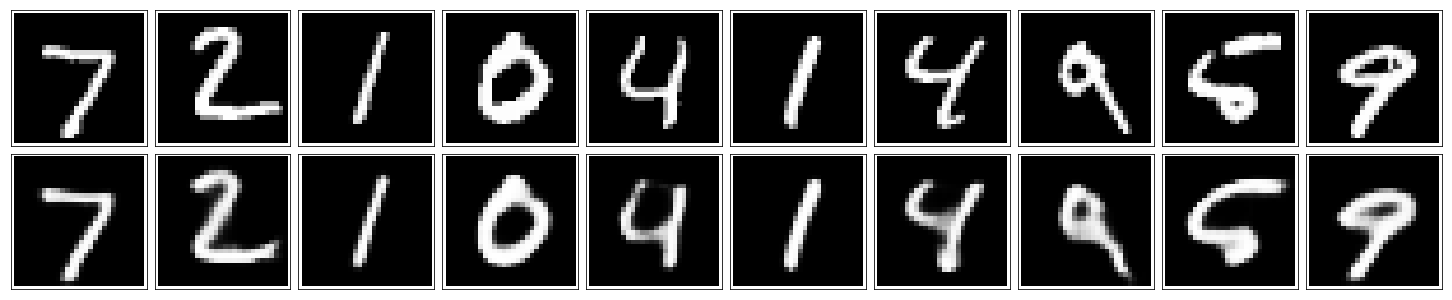

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [19]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [21]:
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

In [22]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

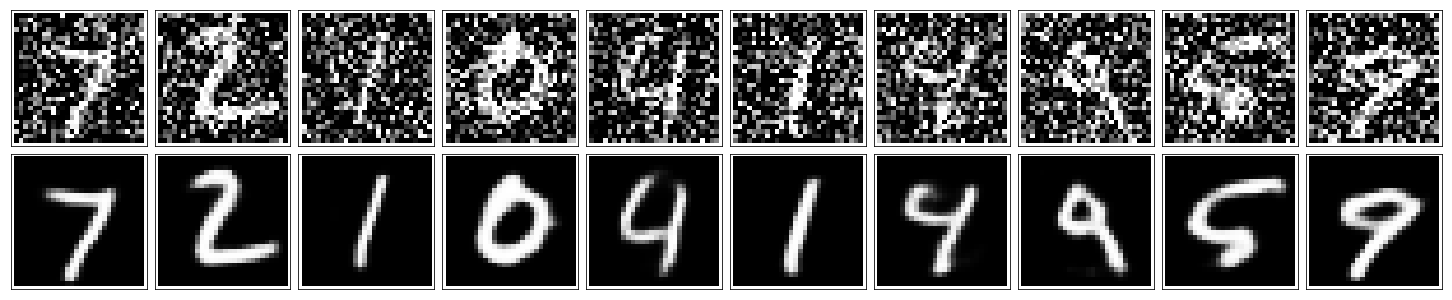

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)